# Survival analysis using lifelines in Python

Survival analysis is used for modeling and analyzing survival rate (likely to survive) and hazard rate (likely to die).

Let’s start with an example:

Here we load a dataset from the lifelines package. I am only looking at 21 observations in my example. The survival analysis dataset contains two columns: T representing durations, and E representing censoring, whether the death has observed or not. Censoring is what makes survival analysis special. There are events you haven’t observed yet but you can’t drop them from your dataset.

For example, in our dataset, for the first individual (index 34), he/she has survived until time 33, and the death was observed. But for the individual in index 39, he/she has survived at 61, but the death was not observed.


In [1]:
from lifelines.datasets import load_waltons
df = load_waltons()
df1 = df.iloc[34:55][['T','E']]
df1

,T,E
34,33.0,1
35,54.0,1
36,54.0,1
37,61.0,1
38,61.0,1
39,61.0,0
40,61.0,1
41,61.0,0
42,61.0,1
43,61.0,1


# Kaplan-Meiser Estimate

The easiest way to estimate the survival function is through the Kaplan-Meiser Estimator. Equation is shown below .It’s basically counting how many people has died/survived at each time point. $d_i$ represents number of deaths events at time $t_i$, $n_i$ represents number of people at risk of death at time $t_i$.
Again, use our example of 21 data points, at time 33, one person our of 21 people died. Thus, the survival rate at time 33 is calculated as 1–1/21. At time 54, among the remaining 20 people 2 has died. At time 61, among the remaining 18, 9 has dies. At time 67, we only have 7 people remained and 6 has died. We can see that Kaplan-Meiser Estimator is very easy to understand and easy to compute even by hand.
$\hat{S}(t) = \prod_{t_i < t}(1-\frac{d_i}{n_i})$


$\hat{S}(33) = (1-\frac{1}{21}) = 0.95$  
$\hat{S}(54) = 0.95 (1-\frac{2}{20}) = 0.86$  
$\hat{S}(61) = 0.95*0.86* (1-\frac{9}{18}) = 0.43$  
$\hat{S}(69) = 0.95*0.86*0.43* (1-\frac{6}{7}) = 0.06$  



Here we get the same results if we use the KaplanMeierFitter in lifeline. In addition to the functions below, we can get the event table from kmf.event_table , median survival time (time when 50% of the population has died) from kmf.median_survival_times , and confidence interval of the survival estimates from kmf.confidence_interval_ .

In [4]:
T = df1['T']
E = df1['E']
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)
kmf.survival_function_


,KM_estimate
timeline,
0.0,1.000000
33.0,0.952381
54.0,0.857143
61.0,0.428571
69.0,0.061224


<AxesSubplot:xlabel='timeline'>

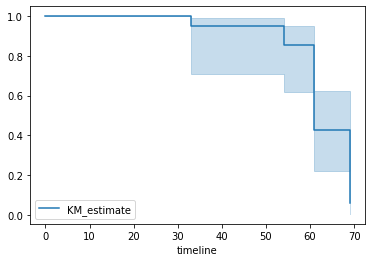

In [6]:
kmf.plot_survival_function()

# Nelson Aalen Estimate
Nelson Aalen estimator estimates hazard rate first with the following equations. $d_i$ represents number of deaths events at time $t_i$, $n_i$ represents number of people at risk of death at time $t_i$. We can get all the harzard rate through simple calculations shown below.


${\tilde  {H}}(t)=\sum _{{t_{i}\leq t}}{\frac  {d_{i}}{n_{i}}}$

with ${\displaystyle d_{i}}$ the number of events at ${\displaystyle t_{i}}$ and ${\displaystyle n_{i}}$ the total individuals at risk at ${\displaystyle t_{i}}$.

$\hat{H}(33) = \frac{1}{21} = 0.04$  
$\hat{H}(54) = \frac{1}{21}+\frac{2}{20} = 0.15$  
$\hat{H}(61) = \frac{1}{21}+\frac{2}{20}+\frac{9}{18} = 0.65$  
$\hat{H}(69) = \frac{1}{21}+\frac{2}{20}+\frac{9}{18}+\frac{6}{7} = 1.50$  

Again, we can easily use `lifeline` to get the same results.

In [8]:
from lifelines import NelsonAalenFitter
naf = NelsonAalenFitter(nelson_aalen_smoothing=False)
naf.fit(T, event_observed=E)
naf.cumulative_hazard_

,NA_estimate
timeline,
0.0,0.000000
33.0,0.047619
54.0,0.147619
61.0,0.647619
69.0,1.504762


<AxesSubplot:xlabel='timeline'>

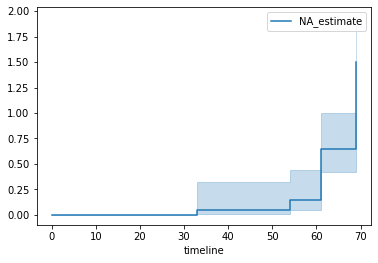

In [9]:
naf.plot_cumulative_hazard()

Kaplan-Meier and Nelson-Aalen models are non-parametic. They are simple to interpret, but no functional form, so that we can’t model a distribution function with it. This is where the exponential model comes handy.

# Exponential model
Exponential distribution is based on the poisson process, where the event occur continuously and independently with a constant event rate 𝜆. Exponential distribution models how much time needed until an event occurs with the pdf 𝑓(𝑡)=𝜆𝑒xp(−𝜆𝑡) and cdf 𝐹(𝑡)=𝑝(𝑇≤𝑡)=1−𝑒xp(−𝜆𝑡).

- $f(t) = \lambda e^{(-\lambda t)}$
- $F(t) = p(T\leq t) = 1- e^{(-\lambda t)}$
- F(t) probablitiy not surviving pass time t


The cdf of the exponential model indicates the probability not surviving pass time t, but the survival function is the opposite. Thus, for survival function:

- $s(t) = p(T>t) = 1-p(T\leq t)= 1-F(t) = \exp({-\lambda t})  $

- $h(t) = \lambda$

- $H(t) = \lambda t$

Note that lifelines use the reciprocal of 𝜆, which doesn’t really matter. We can see that the exponential model smoothes out the survival function.

<AxesSubplot:>

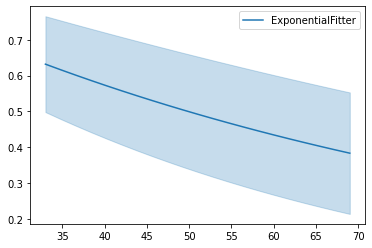

In [10]:
from lifelines import ExponentialFitter
exf = ExponentialFitter().fit(T, E, label='ExponentialFitter')
exf.plot_survival_function()

# Weibull model
Exponential distribution is a special case of the Weibull distribution: x~exp(𝜆)~ Weibull (1/𝜆,1). The cdf of the Weibull distribution is 𝐹(𝑡)=1−exp(−(𝑡/𝜆)𝜌)

- $\rho$ < 1: failture rate decreases over time 
- $\rho$ = 1: failture rate is constant (exponential distribution) 
- $\rho$ < 1: failture rate increases over time 

Again, we can write the survival function as 1-F(t):

- $s(t) = \exp(-(t/\lambda)^\rho)  $

- $h(t) =\rho/\lambda (t/\lambda )^{\rho-1}$

- $H(t) = (t/\lambda )^\rho$

<AxesSubplot:>

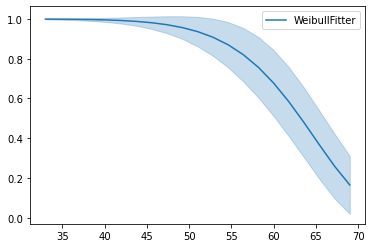

In [11]:
from lifelines import WeibullFitter
wbf = WeibullFitter().fit(T, E, label='WeibullFitter')
wbf.plot_survival_function()

## Model selection
We talked about four types of univariate models: Kaplan-Meier and Nelson-Aalen models are non-parametric models, Exponential and Weibull models are parametric models. There are a lot more other types of parametric models. Which model do we select largely depends on the context and your assumptions. Statistically, we can use QQ plots and AIC to see which model fits the data better. More info see https://lifelines.readthedocs.io/en/latest/Examples.html#selecting-a-parametric-model-using-qq-plots.


# Survival regression
The general function of survival regression can be written as:

hazard = $\exp(b_0+b_1x_1+b_2x_2...b_kx_k)$

which represents that hazard is a function of Xs.


## Exponential model
Exponential survival regression is when 𝑏0 is constant.

## Cox’s proportional hazard model
Cox’s proportional hazard model is when $b_0$ becomes $ln(b_0(t))$, which means the baseline hazard is a function of time.

$h(t|x)=b_0(t)exp(\sum\limits_{i=1}^n b_ix_i)$ 

- $ℎ(𝑡|𝑥)$ hazard 
- $𝑏_0(𝑡)$ baseline hazard, time-varying  
- $exp(\sum\limits_{i=1}^n b_ix_i)$ partial hazard, time-invariant
- $x_i$is often centered to the mean


### Pro
- can fit survival models without knowing the distribution
- with censored data, inspecting distributional assumptions can be difficult
- no need to specify the underlying hazard function, great for estimating covariate effects and hazard ratios.

### Con
- estimate 𝑏0,…𝑏𝑘 without having to specify 𝑏0(𝑡)
- can not estimate s(t) and h(t)

### Assumptions
1. Non-informative censoring 
check: predicting censor by Xs

2. survival times (t) are independent

3. ln(hazard) is linear function of numeric Xs. 
check: residual plots 
fix: transformations  

4. Values of Xs don’t change over time.
fix: add time-varying covariates 

5. Harzards are proportional. Hazard ratio between two subjects is constant. 
check: Schoenfeld residuals, proportional hazard test  
fix: add non-linear term, binning the variable, add an interaction term with time, stratification (run model on subgroup), add time-varying covariates.

The most important assumption of Cox’s proportional hazard model is the proportional hazard assumption. But we may not need to care about the proportional hazard assumption. As mentioned in Stensrud (2020), “There are legitimate reasons to assume that all datasets will violate the proportional hazards assumption”.

Here is an example of the Cox’s proportional hazard model directly from the lifelines webpage (https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html). One thing to note is the exp(coef) , which is called the hazard ratio. The `exp(coef)` of marriage is 0.65, which means that for at any given time, married subjects are 0.65 times as likely to dies as unmarried subjects.

In [12]:
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi
rossi_dataset = load_rossi()
cph = CoxPHFitter()
cph.fit(rossi_dataset, duration_col='week', event_col='arrest')
cph.print_summary()  

Finally, if the features vary over time, we need to use time varying models, which are more computational taxing but easy to implement in lifelines.

## Aalen's additive model 
$h(t|x)= b_0(t)+b_1(t)x_1+...b_N(t)x_N$ 

## Cox's time varying proportional hazard model
$h(t|x)=b_0(t)exp(\sum\limits_{i=1}^n \beta_i(x_i(t)) - \bar{x_i})$ 

# Model selection

## Survival probability calibration plot
The survival probability calibration plot compares simulated data based on your model and the observed data. It provides a straightforward view on how your model fit and deviate from the real data. This is implemented in `lifelines lifelines.survival_probability_calibration` function.

## Compare model fit statistics
We can run multiple models and compare the model fit statistics (i.e., AIC, log-likelihood, and concordance). Model with a smaller AIC score, a larger log-likelihood, and larger concordance index is the better model.

## Out-of-sample validation
We can also evaluate model fit with the out-of-sample data. Here we can investigate the out-of-sample log-likelihood values. This is especially useful when we tune the parameters of a certain model.

## Within-sample validation
AIC is used when we evaluate model fit with the within-sample validation. Again smaller AIC value is better.

## Cross validation
K-folds cross validation is also great at evaluating model fit. This is implemented in lifelines lifelines.utils.k_fold_cross_validation function.


References:  
https://www.youtube.com/watch?v=vX3l36ptrTU   
https://lifelines.readthedocs.io/   
https://stats.stackexchange.com/questions/64739/in-survival-analysis-why-do-we-use-semi-parametric-models-cox-proportional-haz   
https://stats.stackexchange.com/questions/399544/in-survival-analysis-when-should-we-use-fully-parametric-models-over-semi-param   
https://jamanetwork.com/journals/jama/article-abstract/2763185   
Stensrud MJ, Hernán MA. Why Test for Proportional Hazards? JAMA. Published online March 13, 2020. doi:10.1001/jama.2020.1267


By Sophia Yang on [January 9, 2020](https://medium.com/analytics-vidhya/survival-analysis-using-lifelines-in-python-bf5eb0435dec)